# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [138]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [342]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id",]
df_transactions['n'] = 1
df_transactions = df_transactions.reset_index()
df_transactions

,index,customer_name,offer_id,n
0,0,Smith,2,1
1,1,Smith,24,1
2,2,Johnson,17,1
3,3,Johnson,24,1
4,4,Johnson,26,1
5,5,Williams,18,1
6,6,Williams,22,1
7,7,Williams,31,1
8,8,Brown,7,1
9,9,Brown,29,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn

purchases = pd.DataFrame(columns=['index','customer_name'])
purchases


,index,customer_name


In [5]:
purchases = df_transactions[['index','customer_name']]
purchases

,index,customer_name
0,0,Smith
1,1,Smith
2,2,Johnson
3,3,Johnson
4,4,Johnson
5,5,Williams
6,6,Williams
7,7,Williams
8,8,Brown
9,9,Brown


In [6]:
pd.pivot_table(df_transactions,index=['index'],columns=['offer_id'],values=['n']).reset_index()

index    n                                      ...                 \
offer_id          1    2   3    4   5    6    7    8   9 ...   23   24   25   
0            0  NaN  1.0 NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
1            1  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  1.0  NaN   
2            2  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
3            3  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  1.0  NaN   
4            4  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
5            5  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
6            6  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
7            7  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
8            8  NaN  NaN NaN  NaN NaN  NaN  1.0  NaN NaN ...  NaN  NaN  NaN   
9            9  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
10          10  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
11          11  NaN  NaN NaN  NaN NaN  NaN  NaN  1.0 NaN ...  NaN  NaN  NaN   
12          12  NaN  NaN NaN  NaN NaN  1.0  NaN  NaN NaN ...  NaN  NaN  NaN   
13          13  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
14          14  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
15          15  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
16          16  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
17          17  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  1.0  NaN  NaN   
18          18  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
19          19  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
20          20  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
21          21  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  1.0   
22          22  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
23          23  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
24          24  NaN  1.0 NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
25          25  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
26          26  NaN  NaN NaN  NaN NaN  NaN  NaN  1.0 NaN ...  NaN  NaN  NaN   
27          27  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
28          28  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
29          29  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  1.0   
..         ...  ...  ...  ..  ...  ..  ...  ...  ...  .. ...  ...  ...  ...   
294        294  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
295        295  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
296        296  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
297        297  NaN  NaN NaN  NaN NaN  NaN  NaN  1.0 NaN ...  NaN  NaN  NaN   
298        298  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  1.0  NaN   
299        299  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
300        300  NaN  NaN NaN  NaN NaN  1.0  NaN  NaN NaN ...  NaN  NaN  NaN   
301        301  NaN  NaN NaN  NaN NaN  NaN  NaN  1.0 NaN ...  NaN  NaN  NaN   
302        302  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
303        303  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
304        304  NaN  NaN NaN  NaN NaN  NaN  NaN  1.0 NaN ...  NaN  NaN  NaN   
305        305  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
306        306  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
307        307  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
308        308  1.0  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
309        309  NaN  NaN NaN  1.0 NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
310        310  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ...  NaN  NaN  NaN   
311        311  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN NaN ..

In [7]:
# pivot_table performs the same function as groupby, but the resulting table has a different shape
# this shape allows us to efficiently merge data, as in this case.
# manually set the columns so that the shape of the dataframe is corrected (to perform the merge)

pivot = pd.pivot_table(df_transactions,index=['index'],columns=['offer_id'],values=['n']).reset_index()
columns = ['index'] + list(range(1,33))
pivot.columns = columns
pivot

,index,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [8]:
purchases = purchases.merge(pivot,how='left',on='index')
purchases

,index,customer_name,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,0,Smith,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Johnson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Johnson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Johnson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,5,Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
8,8,Brown,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,Brown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [9]:
purchases = purchases.fillna(0)
for col in purchases.columns[2:len(purchases.columns)]:
    purchases[col] = purchases[col].astype(int)
purchases

,index,customer_name,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,0,Smith,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Smith,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,Johnson,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Johnson,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,4,Johnson,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,5,Williams,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,Williams,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,Williams,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,8,Brown,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,9,Brown,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [10]:
# your turn

# to an extent, smaller values for SS represent better clusterings. by treating the centroid as a "mean,"
# data points around the centroid can be thought of as variations from this mean, while belonging to the
# same cluster (minimize this sum of squared distances, as we do in regression).
# however, this is only true while the SS steeply drops. as the rate of decrease of SS slows, it is likely
# that we have begun to overfit. (e.g. if we had as many clusters as we had data points, we could achieve
# SS = 0, by having every centroid aligned with every data point. this would clearly be an overfit)
# thus, by graphical observation of K vs. SS should have a steep drop off ("elbow") which we can use 
# as a guide for our choice of K


In [26]:
x_cols = purchases[purchases.columns[2:len(purchases.columns)]].as_matrix()
x_cols

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

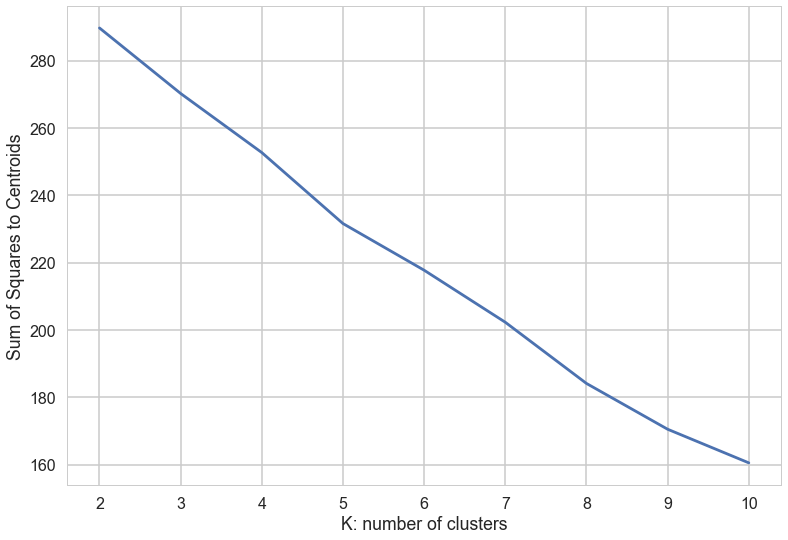

In [102]:
# .intertia_ attribute returns sum of distances. not sure if these are squared but this will represent the trend

from sklearn.cluster import KMeans

SS = []
K_values = list(range(2,11)) 

for K in K_values:
    kmeans = KMeans(n_clusters=K).fit(x_cols)
    SS.append(kmeans.inertia_)
    
plt.plot(K_values,SS)
plt.xlabel('K: number of clusters')
plt.ylabel('Sum of Squares to Centroids')

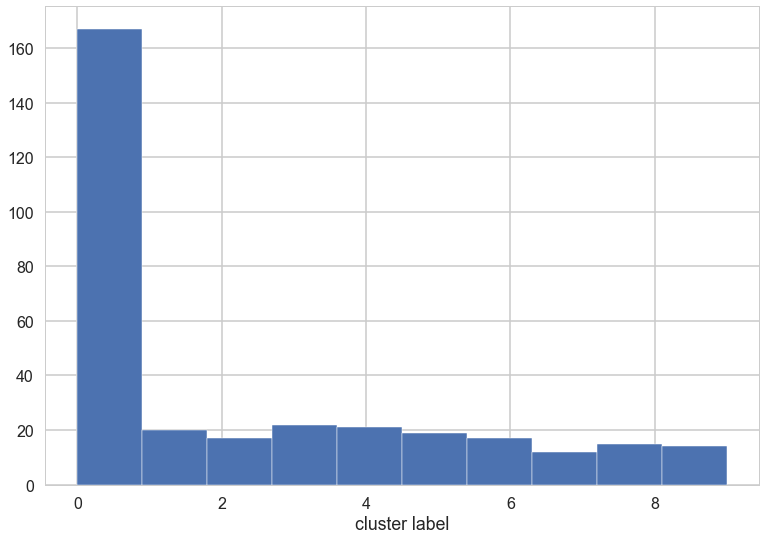

In [103]:
# .labels_ attribute returns an array with the labels for each point. (cluster the point was assigned to)
# remember: each row in the matrix corresponds to a point.
# KMeans is not deterministic... result of the labels changes with each run (seed centroids change with each run)
# however, if we increase the max_iter parameter, we will get more consistent results
# aside: random_state parameter can be set to a deterministic seed

kmeans = KMeans(n_clusters=10,max_iter=1500).fit(x_cols)
plt.hist(kmeans.labels_,edgecolor='w')
plt.xlabel('cluster label')

In [ ]:
# this method didn't actually result in any elbow ("good" cutoff for K)
# even if we increase the range of K values we test on, the K vs. SS plot decreases almost linearly until 
# it reaches 0 (overfit).

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [153]:
K_values = list(range(2,15))

For n_clusters = 2 The average silhouette_score is : 0.103010540995
For n_clusters = 3 The average silhouette_score is : 0.163064013005
For n_clusters = 4 The average silhouette_score is : 0.22559354226
For n_clusters = 5 The average silhouette_score is : 0.26284348865
For n_clusters = 6 The average silhouette_score is : 0.305027962435
For n_clusters = 7 The average silhouette_score is : 0.383938689092
For n_clusters = 8 The average silhouette_score is : 0.420481164926
For n_clusters = 9 The average silhouette_score is : 0.465294924554
For n_clusters = 10 The average silhouette_score is : 0.501690182246
For n_clusters = 11 The average silhouette_score is : 0.54329004329
For n_clusters = 12 The average silhouette_score is : 0.581998073724
For n_clusters = 13 The average silhouette_score is : 0.612289133918
For n_clusters = 14 The average silhouette_score is : 0.642485460667


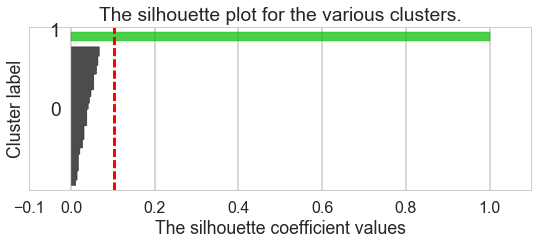

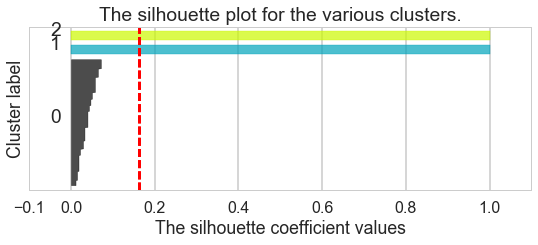

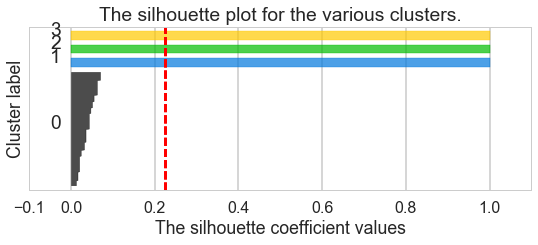

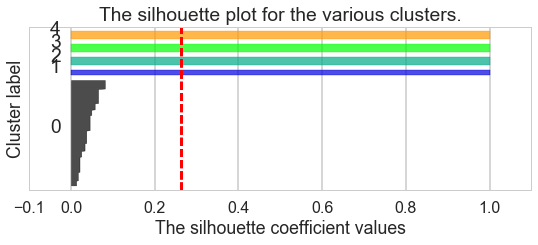

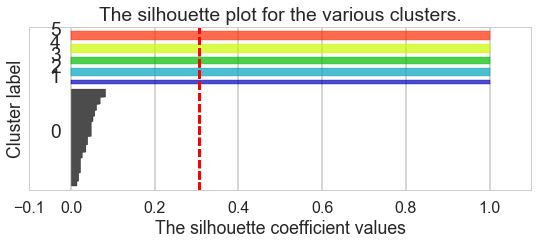

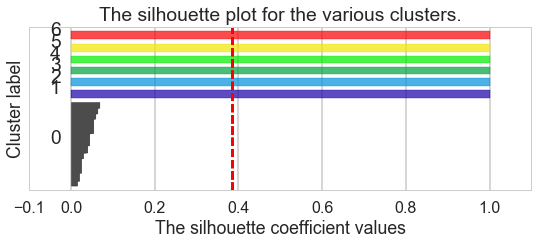

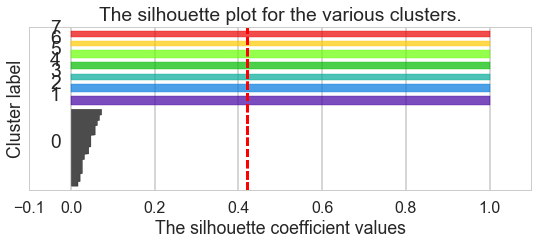

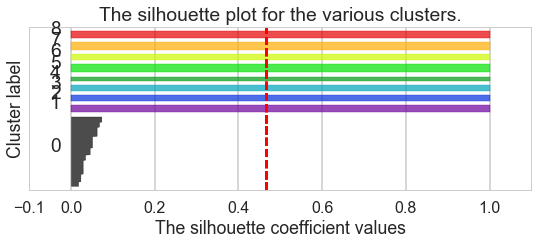

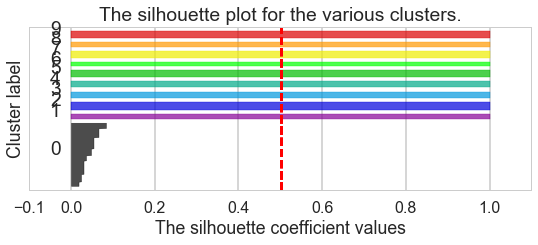

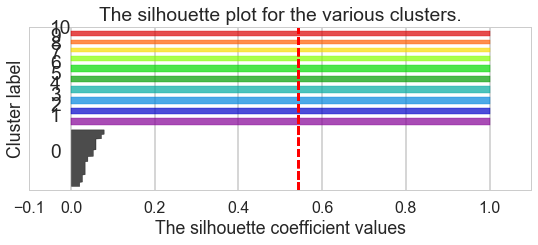

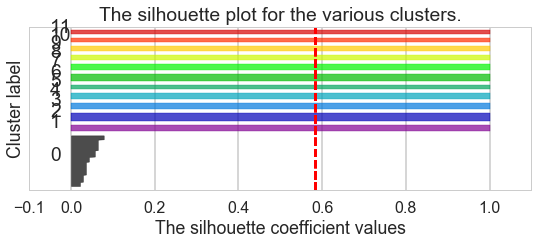

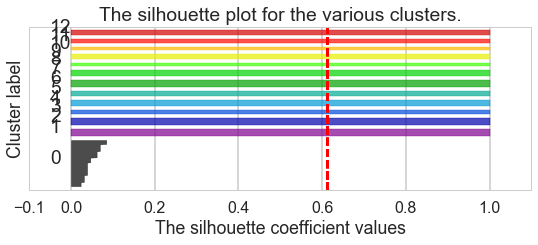

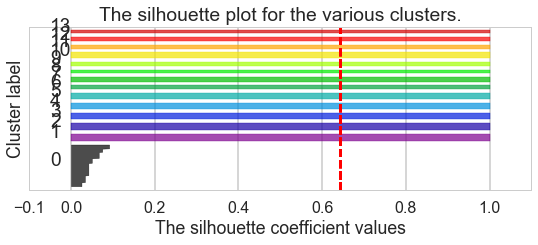

In [155]:
# Your turn.

from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

for k in K_values:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 3)
    ax1.set_xlim([-0.1, 1.1])
    ax1.set_ylim([0, len(x_cols) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k).fit(x_cols)
    sil_avg = silhouette_score(x_cols,clusterer.labels_)
    print("For n_clusters =", k,
          "The average silhouette_score is :", sil_avg)
    
    sil_values = silhouette_samples(x_cols,clusterer.labels_)
    
    y_lower = 10
    for i in range(k):
        label_i_sil = sil_values[clusterer.labels_ == i]
        label_i_sil.sort()
        size_cluster_i = label_i_sil.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, label_i_sil,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=sil_avg, color="red", linestyle="--")
        
        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
    

In [162]:
# the result of this analysis is the same as in the elbow method: the average score keeps getting better (almost linearly)
# as we increase K, leading us to think we should keep increasing K until we reach 32..but again, that seems like an overfit
# the sil score for non-zero labels are all 1, indicating a very good cluster
# this might leads you to think that there is not actually a good clustering for this dataset and that
# the label 0 data points are all clusters "incorrectly" in a single blob, 
# while the other data points each get their own cluster. however, this line of code below vv
# shows that this is not true. for label 13, there are several data points in this cluster..apparently
# all with a very good fit (since the values are 0 or 1, the fit ends up being either very good or very bad..as indicated)

clusterer.labels_[clusterer.labels_ == 13]

array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13])

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [232]:
pca_x = []
pca_y = []

for row in pca:
    pca_x.append(row[0])
    pca_y.append(row[1])

In [233]:
#your turn

from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(x_cols)
purchases_pca = df_transactions[['customer_name']]
purchases_pca['cluster_label'] = clusterer.labels_
purchases_pca['pca_x'] = pca_x
purchases_pca['pca_y'] = pca_y

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


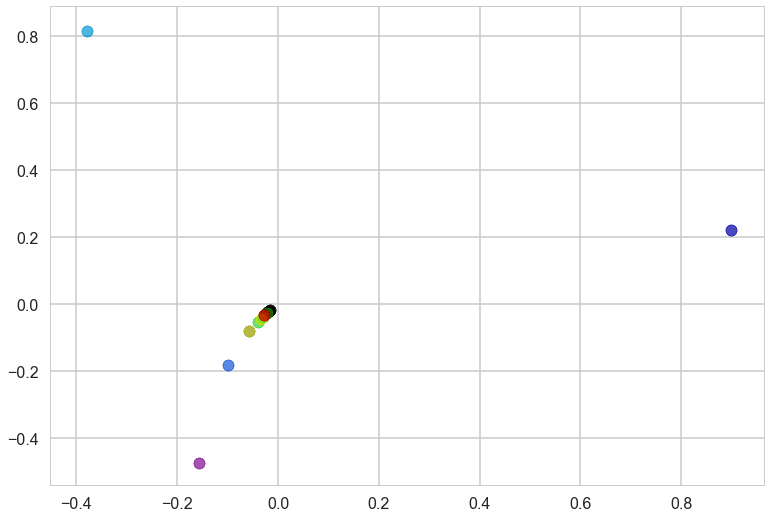

In [234]:
for i in range(max(clusterer.labels_)):
    color1 = cm.spectral(float(i) / max(clusterer.labels_))
    plt.scatter(purchases_pca[purchases_pca['cluster_label']==i]['pca_x'],purchases_pca[purchases_pca['cluster_label']==i]['pca_y'],color=color1,alpha=0.05)

In [ ]:
# within any one cluster, the points are very close together. (they look as if they are one point--they overlap significantly)
# this is so much so that it even appears that we've made too many clusters; there exist several clusters within an area
# that visually appears to be one cluster. this may be a result of the dimensionality reduction

# based on the plot, K value of 5 seems more appropriate than the 13 we used here. 

In [235]:
clusterer1 = KMeans(n_clusters=5).fit(x_cols)
purchases_pca['cluster_label'] = clusterer1.labels_

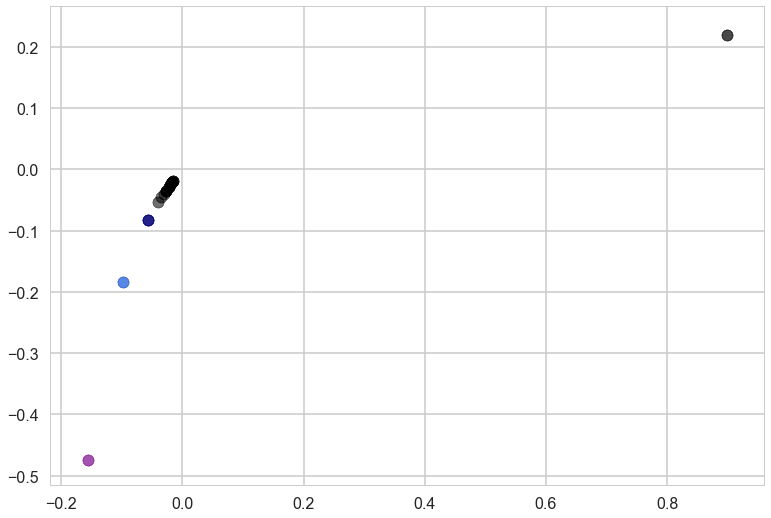

In [236]:
for i in range(max(clusterer1.labels_)):
    color1 = cm.spectral(float(i) / max(clusterer.labels_))
    plt.scatter(purchases_pca[purchases_pca['cluster_label']==i]['pca_x'],purchases_pca[purchases_pca['cluster_label']==i]['pca_y'],color=color1,alpha=0.05)

In [ ]:
# strange behavior--there seems to be a cluster within another, but overall this seems like a better job done than the previous
# again, this is probably a result of dimensionality reduction
# i.e. variables are being mapped to a lower dimension where they appear similar where they may not have been
# asides from this strange behavior, this indeed seems to be a better cluster than the k = 14 used above

In [319]:
df_offers[['min_qty','discount']].describe()

,min_qty,discount
count,32.000000,32.000000
mean,65.812500,57.843750
std,50.785722,20.770807
min,6.000000,17.000000
25%,12.000000,44.750000
50%,72.000000,55.000000
75%,72.000000,82.250000
max,144.000000,89.000000


In [345]:
offer_cluster = np.unique(df_transactions[purchases_pca['cluster_label'] == 0]['offer_id']) - 1
df_offers.iloc[offer_cluster]

# 0 label seems to have the greatest variety, i.e. we did not use enough clusters for all the data points
# to cluster nicely, so these "outliers" (given the number of clusters we used) are clumped together in
# a cluster.. this does not actually seem to be a category within the data set

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False
10,11,May,Champagne,72,85,France,False
11,12,May,Prosecco,72,83,Australia,False


In [350]:
offer_cluster = np.unique(df_transactions[purchases_pca['cluster_label'] == 1]['offer_id']) - 1
df_offers.iloc[offer_cluster]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
7,8,March,Espumante,6,45,South Africa,False


In [351]:
offer_cluster = np.unique(df_transactions[purchases_pca['cluster_label'] == 2]['offer_id']) - 1
df_offers.iloc[offer_cluster]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
30,31,December,Champagne,72,89,France,False


In [352]:
offer_cluster = np.unique(df_transactions[purchases_pca['cluster_label'] == 3]['offer_id']) - 1
df_offers.iloc[offer_cluster]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True


In [349]:
offer_cluster = np.unique(df_transactions[purchases_pca['cluster_label'] == 4]['offer_id']) - 1
df_offers.iloc[offer_cluster]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
21,22,August,Champagne,72,63,France,False


In [353]:
# the clusters all seem to be separating single offers..this is representative of the fact that 
# SS seemed to decrease linearly when we searched for the "elbow point"
# in other words, as we increase the number of clusters, a distinct offer gets put in its own cluster
# the offers seem to be distinct enough that they are split into separate clusters,
# except for the 0 label cluster, which groups together the clusters which do not fit in any of the other
# given clusters

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [250]:
dimensions = list(range(1,33))

In [251]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition

for di in dimensions:
    pca = sklearn.decomposition.PCA(n_components=di)
    pca.fit(x_cols)
    pca.transform(x_cols)

pca.explained_variance_

# Do the rest on your own :)


array([  6.69861881e-02,   6.36791134e-02,   6.03945254e-02,
         5.65444782e-02,   5.24691358e-02,   4.92679222e-02,
         4.50282335e-02,   4.19558652e-02,   3.91978910e-02,
         3.70370370e-02,   3.70370370e-02,   3.35524157e-02,
         3.08641975e-02,   3.08641975e-02,   2.87837060e-02,
         2.77777778e-02,   2.37537994e-02,   2.16049383e-02,
         2.04335427e-02,   1.85185185e-02,   1.85185185e-02,
         1.85185185e-02,   1.85185185e-02,   1.85185185e-02,
         1.62359029e-02,   1.54320988e-02,   1.54320988e-02,
         1.54320988e-02,   1.28474436e-02,   1.23456790e-02,
         1.23456790e-02,   1.33360326e-31])

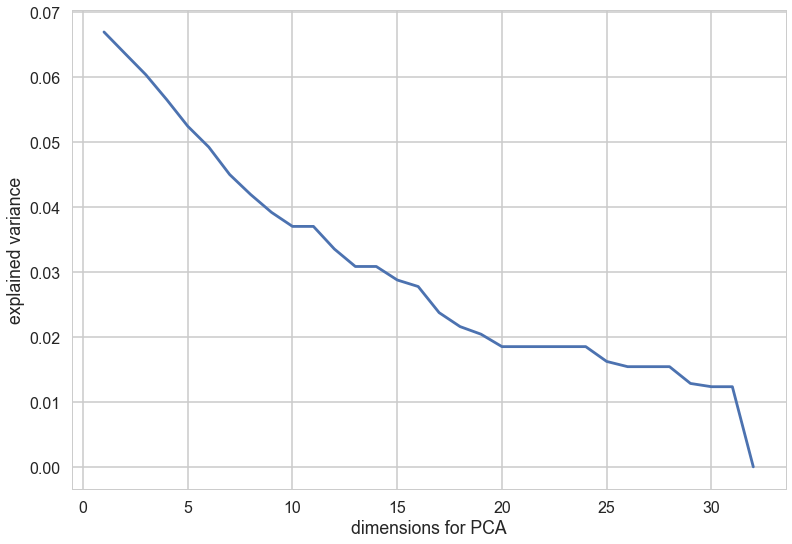

In [254]:
plt.plot(dimensions,pca.explained_variance_)
plt.xlabel('dimensions for PCA')
plt.ylabel('explained variance')

In [ ]:
# the elbow point ('optimal number of dimensions') seems to be at 20

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [ ]:
# Your turn

In [308]:
from sklearn.cluster import AffinityPropagation
AP = AffinityPropagation().fit(x_cols)
print(len(AP.cluster_centers_indices_))
AP.labels_

# AP comes up with 168 clusters when we use the default damping paramter 0.5

168


array([101,   0,  86,   1,   2,   3,   4,   5,   6,   7, 160,   8,  47,
        61, 143,  26,   9,  58,  10, 113,  11,  28, 143,  26, 101,  12,
        13,  17, 113,  28,  14,  15,  16,  17,  18,  19,   1,  70, 103,
        50,  20, 143,  21,  14,  22,  86,  23, 101,  24,  14,  70, 101,
        25,  26,  27,  50, 130,  28, 164, 143,  29,  28,  90,  50,  30,
        26, 130,  82,  31, 103, 120,  32,  82,  50,  33,  36,  47,  34,
        62,  35,  82,  36,  37,  14,  38,  39,  40,  16,  41,  42,  43,
        65,  44,  56,  45,  46,  47,  50,  26,  48,  49, 104,  50,  82,
        53, 105, 143,  26, 110,  51,  52,  53,  47,  97,  82,  54,  55,
        56,  57,  47, 143,  58,  59,  60,  61,  62,  63,  64,  65,  73,
        31, 103, 133,  66,  67,  55, 153,  54,  50, 101,  68,  69,  70,
       101,  71,  72,  55,  73, 104,  86,  74, 166,  82,  53,  47,  82,
        75,  76,  77, 130, 110,  78,  79,  80,  49,  81,  82,  83,  84,
        28,  86,  85,  86,  87,  88,  62,  89,  90, 113,  91,  9

In [285]:
from sklearn.cluster import SpectralClustering

SC = SpectralClustering().fit(x_cols)

# ..? how do we evaluate this algorithm? also, how do we choose the number of clusters?

In [292]:
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering().fit(x_cols)

# again, how do we pick these parameters? and how do we evaluate the algorithm?

In [304]:
from sklearn.cluster import DBSCAN

DB = DBSCAN().fit(x_cols)
np.unique(DB.labels_)

# regardless of the neighborhood size used, the algorithm comes up with 30 clusters (including the "noisy samples")
# this is far fewer than AffinityPropogation comes up with, with its default parameter
# although AP results in a similar number of clusters if we increase damping towards 

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int64)